In [ ]:
!unzip /content/drive/MyDrive/datasets/glove.zip -d /content/

In [ ]:
!apt install libomp-dev
!pip install faiss
!pip install faiss-gpu
import faiss  

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [ ]:
!pip install --upgrade xgboost
from xgboost import XGBClassifier

Requirement already up-to-date: xgboost in /usr/local/lib/python3.7/dist-packages (1.4.2)


In [1]:
import pandas as pd
import numpy as np
import re
import sys
import json
import csv
import gc
from collections import Counter
import glob
import os.path
import time
import nltk
from random import *
import ast
import os
import joblib
import matplotlib.pyplot as plt
import math
from google.colab import drive
import requests_oauthlib
from scipy.spatial import distance
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)  # or 199

In [3]:
# Load word frequency dataset and create a 'rel_freq' variable indicating 'politicalness' of a word.
df = pd.read_csv("/content/drive/MyDrive/datasets/reddit/extracted_keywords_freq.csv")
df["rel_freq"] = (df["pol_freq"]*df["total_freq"].sum())/(df["total_freq"]*df["pol_freq"].sum())-1

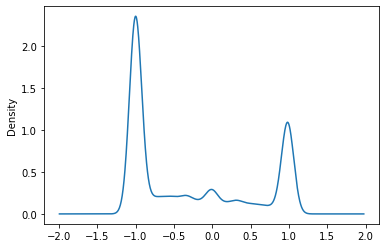

In [4]:
df["rel_freq"].plot.kde()

In [ ]:
df.head(n=50)

In [6]:
#word frequency dict
wfd = dict(zip(df.word, df.total_freq))

def get_most_common(x):  #get most frequent word from a phrase.
  if len(x)<2:
    return x
  word_freq = 0
  word_ret = ""
  for word in x.split():
    if (word in ["null","nan"]):
      continue
    elif (wfd[word]>word_freq):
      word_ret = word
      word_freq = wfd[word]
  return word_ret

def split_words(lst):
  ret_list = []
  for i in lst:
    ret_list.append(get_most_common(i))
  return ret_list

In [7]:
# Test and train dataset. Contains keywords extracted from paragraph using textrank.
df_main = pd.read_csv("/content/drive/MyDrive/datasets/reddit/train_dataset.csv")
df_main["keywords"] = df_main["keywords"].apply(ast.literal_eval)
df_main["text_rank_scores"] = df_main["text_rank_scores"].apply(ast.literal_eval)
df_main["keywords"] = df_main["keywords"].apply(split_words) #Resolve compound words.
df_main = df_main.sample(frac=1).reset_index(drop=True) #Shuffle

In [81]:
#test train splits for both categories
split_pos = 0.5
split_neg = 0.5

#removing some subreddits that are hard to classify. 
df_main = df_main[~df_main["subreddit"].isin(("badeconomics","askeconomics", "economics","politicalcompassMemes"))]

df_pos = df_main[df_main["label"]==1]
df_neg = df_main[df_main["label"]==0]

df_pos_train,df_pos_test = train_test_split(df_pos, test_size=split_pos)
df_neg_train,df_neg_test = train_test_split(df_neg, test_size=split_neg)

df_train = pd.concat([df_pos_train, df_neg_train], ignore_index=True)
df_test = pd.concat([df_pos_test, df_neg_test], ignore_index=True)

In [83]:
len_pos = len(df_pos_train)
len_neg = len(df_neg_train)
len_tot = len_pos+len_neg
print(f"pos: {len_pos/len_tot}, neg: {len_neg/len_tot}")

pos: 0.5275150830958285, neg: 0.47248491690417144


In [84]:
len_pos = len(df_pos_test)
len_neg = len(df_neg_test)
len_tot = len_pos+len_neg
print(f"pos: {len_pos/len_tot}, neg: {len_neg/len_tot}")

pos: 0.5275150830958285, neg: 0.47248491690417144


In [13]:
rel_freq_dict = dict(zip(df["word"], df["rel_freq"]))

def get_rel_freq(x,text_rank_scores):
  try:
    ret = [rel_freq_dict[x]]
  except:
    ret = [0.0] # not found
  return ret

def get_x(xs,text_rank_scores):
  ret_val = []
  
  for i in range(len(xs)):
    ret_val.extend(get_rel_freq(xs[i],text_rank_scores[i]))

  ret_val = np.sort(np.array(ret_val))[::-1]
  ret_val = np.pad(ret_val, (0, max(0,10-len(ret_val))), 'constant') # Padding to 10 items
  return ret_val

In [85]:
x_train = np.stack(df_train.apply(lambda row: get_x(row["keywords"],row["text_rank_scores"]), axis=1))
y_train = np.array(df_train.label.astype(int))

x_test = np.stack(df_test.apply(lambda row: get_x(row["keywords"],row["text_rank_scores"]), axis=1))
y_test = np.array(df_test.label.astype(int))

In [46]:
def plot_cm(cf_matrix):
  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Logistic Regression

Prediction Accuracy on train: 0.9458627900951253
Prediction Accuracy on test: 0.9463254617463078


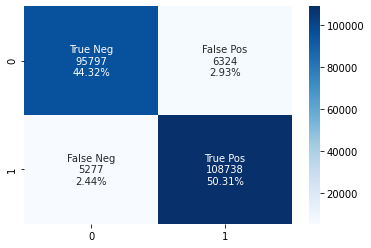

In [86]:
lr = LogisticRegression(random_state=0,max_iter=200)
lr.fit(x_train, y_train)

print(f"Prediction Accuracy on train: {lr.score(x_train, y_train)}")
print(f"Prediction Accuracy on test: {lr.score(x_test, y_test)}")
y_pred = lr.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm)

In [48]:
joblib.dump(lr, "lr_train_50_pos.sav")

['lr_train_20_pos.sav']

In [87]:
print(lr.coef_, lr.intercept_)

[[3.93046247 1.81532622 0.99551    0.67375188 0.70904757 0.38134367
  0.8121919  0.74829088 0.83665252 3.05491921]] [-0.98434933]


In [ ]:
## False Negatives
wrong = df_test[(y_pred==0) & (y_test == 1)].keywords
for i in wrong.sample(n=28):
  print(dict(zip(i, get_x(i,[i for i in range(10)]))))

In [ ]:
## False Positives
wrong = df_test[(y_pred==1) & (y_test == 0)].keywords
for i in wrong.sample(n=28):
  print(dict(zip(i, get_x(i,[i for i in range(10)]))))

KNN

In [ ]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [ ]:
fknn = FaissKNeighbors(k=5)
fknn.fit(x_train,y_train)

0.9079040631405528


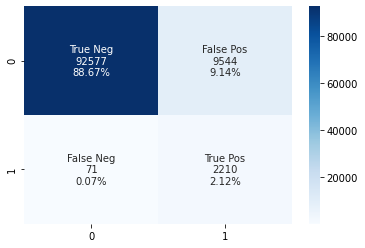

In [ ]:
y_pred = fknn.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

XGBoost

In [ ]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
y_pred = xgb.predict(x_test)
prediction_end = time.perf_counter()
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print(f"XGBoost's prediction accuracy is: {acc_xgb}")
print(f"Time consumed for training: {xgb_train_time}")
print(f"Time consumed for prediction: {xgb_prediction_time}")

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 91.71184460067815
Time consumed for training: 27.78833884100095
Time consumed for prediction: 0.1950870799992117


0.9171184460067815


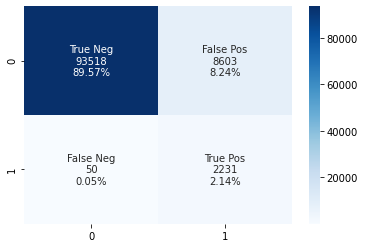

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

Random Forest

In [ ]:
clf=RandomForestClassifier(n_estimators=50,max_depth=40)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9167161548629337


0.9167161548629337


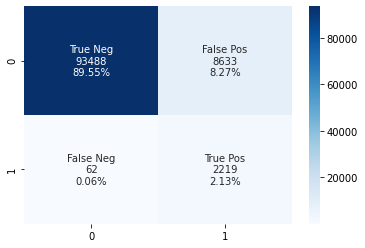

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.accuracy_score(y_test,y_pred))
plot_cm(cm)

Simple Neural Network

In [ ]:
model = Sequential()
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=3,batch_size=10, verbose=1)
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/3
32787/32787 [==============================] - 49s 1ms/step - loss: 0.1543 - accuracy: 0.9474
Epoch 2/3
32787/32787 [==============================] - 49s 1ms/step - loss: 0.1539 - accuracy: 0.9478
Epoch 3/3
3263/3263 [==============================] - 4s 1ms/step - loss: 0.3457 - accuracy: 0.8797
Accuracy: 87.97


Using Embeddings

In [ ]:
embeddings= {}
with open("/content/glove/glove.840B.300d.txt", 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings[word]=vector

In [ ]:
def get_embedding(x):
  try:
    return embeddings[x]
  except:
    return np.zeros(shape=(300))

In [ ]:
word_to_ind = {}
ind_to_word = {}
embeddings_ds = []

for ind,word in enumerate(list(df["word"])):
  word_to_ind[word]=ind
  ind_to_word[ind]=word
  embeddings_ds.append(get_embedding(word))
embeddings_ds = np.array(embeddings_ds,dtype="float32")

In [ ]:
embeddings_ds[:10]

In [ ]:
index = faiss.IndexFlatL2(300)  
index.add(embeddings_ds)
print(index.ntotal)

In [ ]:
get_nearest(x):
  D, I = index.search(np.array([get_embedding(x), 1) # sanity check
  return ind_to_word[I[0][0]]